## `Setup Init`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import lines, patches

import plotly
from plotly.offline import iplot

from flexitext import flexitext

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## `Analyze Data`

Pertama, import data ke dalam pandas dataframe

In [2]:
df = pd.read_csv('../data/processed/cleaned_data.csv', engine='pyarrow').set_index('')
df.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,distance,duration,start_day,ended_day,start_time,ended_time,class_duration,class_distance,weekday
,,,,,,,,,,,,,,,,,,,,,
167541,E61BAEA10F75BB5C,classic_bike,2023-03-24 18:03:41,2023-03-24 18:10:31,Loomis St & Lexington St,13332,Aberdeen St & Jackson Blvd,13157,41.872229,-87.661364,...,member,820.0,6.83,Friday,Friday,18:03:41,18:10:31,0-7.5 minute,750-2100 m,weekend
176377,C809D13BAB29864A,classic_bike,2023-03-28 11:08:39,2023-03-28 11:10:43,Broadway & Waveland Ave,13325,Broadway & Sheridan Rd,13323,41.949074,-87.648636,...,member,430.0,2.07,Tuesday,Tuesday,11:08:39,11:10:43,0-7.5 minute,0-750 m,weekday
445962,410ED5A37F04886F,electric_bike,2023-01-16 18:37:49,2023-01-16 18:53:06,N Carpenter St & W Lake St,20251.0,Michigan Ave & 14th St,TA1307000124,41.890000,-87.650000,...,member,3610.0,15.28,Monday,Monday,18:37:49,18:53:06,> 7.5 minute,> 2100 m,weekend
233704,F1252D863A541289,electric_bike,2023-02-02 08:45:55,2023-02-02 08:48:45,Loomis St & Lexington St,13332,Racine Ave & Congress Pkwy,TA1306000025,41.872200,-87.661383,...,member,450.0,2.83,Thursday,Thursday,08:45:55,08:48:45,0-7.5 minute,0-750 m,weekday
385170,9D7EF5F63160D496,classic_bike,2023-01-31 06:10:50,2023-01-31 06:15:28,Wells St & Huron St,TA1306000012,Orleans St & Chestnut St (NEXT Apts),620,41.894722,-87.634362,...,member,470.0,4.63,Tuesday,Tuesday,06:10:50,06:15:28,0-7.5 minute,0-750 m,weekday


Korelasikan antar variabel dengan `member_casual` untuk melihat keterkaitan diantara mereka:

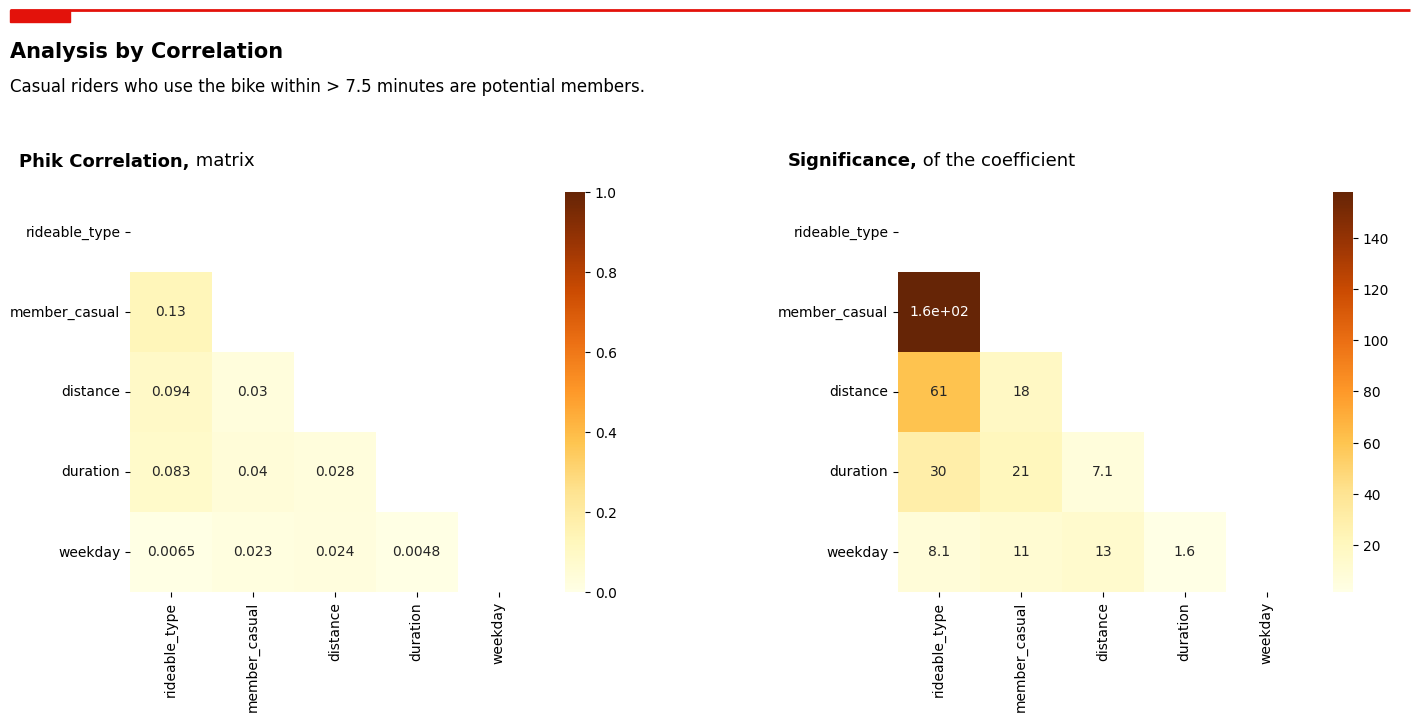

In [32]:
from phik.report import plot_correlation_matrix as pcm

# Inisialisasi variabel
corr_cols = ['rideable_type', 'member_casual', 'distance', 'duration', 'weekday']

# Inisialisasi parameter gambar
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# make room below on top and bottom
plt.subplots_adjust(left=0.06, bottom=0.1, right=0.7, top=0.9, wspace=0.5, hspace=0.1)

# add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 0.7], [1.265, 1.265], lw=2, color='#E3120B', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.24), 0.03, 0.025, color='#E3120B'))

# add title
fig.text(
    0, 1.17, "Analysis by Correlation", 
    fontsize=15,
    fontweight="bold", 
)

# add subtitle
fig.text(
    0, 1.1, 
    "Casual riders who use the bike within > 7.5 minutes are potential members.", 
    fontsize=12, 
    color='black'
)

# add title for histogram plot
text = "<size:13><weight:bold>Phik Correlation,</> matrix </>"
flexitext(-0.27, 1.1, text, va="top", ax=ax[0])

# add title for bar plot
text = "<size:13><weight:bold>Significance,</> of the coefficient</>"
flexitext(-0.27, 1.1, text, va="top", ax=ax[1])

# Matrik koefisien korelasi
corr = df[corr_cols].phik_matrix(interval_cols=['distance', 'duration'])
corr_mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=corr_mask, vmin=0, vmax=1, annot=True, cmap="YlOrBr", ax=ax[0])
plt.yticks(rotation=0)

# Matrix koefisien signifikansi
sig = df[corr_cols].significance_matrix(interval_cols=['distance', 'duration'])
sig_mask = np.triu(np.ones_like(sig, dtype=bool))
sns.heatmap(sig, mask=sig_mask, annot=True, cmap="YlOrBr", ax=ax[1])
plt.yticks(rotation=0)

# Menampilkan grafik
plt.show()

Kemudian, melakukan analisis terhadap masing-masing atribut pada data:

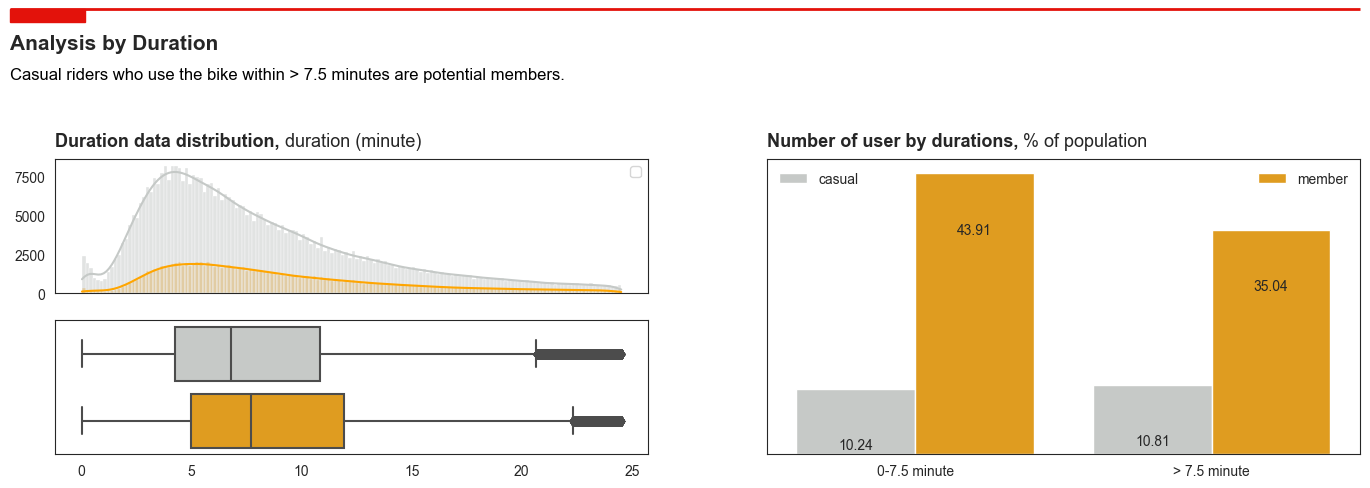

In [21]:
# set the data 
Q1_duration = df['duration'].quantile(0.25)
Q3_duration = df['duration'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration
df_dur = df.query('(@Q1_duration - 1.5 * @IQR_duration) <= duration <= (@Q3_duration + 1.5 * @IQR_duration)')

# figure size
fig =  plt.figure(figsize=(15, 5))

# background color
sns.set_style("white")

# axes configuration
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[:, 1])

# make room below on top and bottom
fig.subplots_adjust(top=0.7, left=0.03)

# add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 0.9], [1, 1], lw=2, color='#E3120B', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='#E3120B'))

# add title
fig.text(
    0, 0.92, "Analysis by Duration", 
    fontsize=15,
    fontweight="bold", 
)

# add subtitle
fig.text(
    0, 0.86, 
    "Casual riders who use the bike within > 7.5 minutes are potential members.", 
    fontsize=12, 
    color='black'
)

# add title for histogram plot
text = "<size:13><weight:bold>Duration data distribution,</> duration (minute)</>"
flexitext(0, 1.2, text, va="top", ax=ax1)

# add title for bar plot
text = "<size:13><weight:bold>Number of user by durations,</> % of population</>"
flexitext(1.2, 1.2, text, va="top", ax=ax1)

# historgram plot
g1 = sns.histplot(
    data=df_dur, 
    x="duration", 
    ax=ax1,
    hue='member_casual', 
    kde=True, 
    palette=['#C5C9C7', '#FFA500'],
)
g1.set(xlabel=None, ylabel=None, xticklabels=[])
g1.legend([])

# boxplot
g2 = sns.boxplot(
    data=df_dur, 
    x="duration", 
    y='member_casual',
    ax=ax2, 
    palette=['#C5C9C7', '#FFA500'],
)
g2.set(xlabel=None, ylabel=None, yticklabels=[])
g2.tick_params(left=False)

# barplot
df_bar = pd.pivot_table(
    data=df_dur,
    index=['member_casual', 'class_duration'],
    values='ride_id',
    aggfunc='count').reset_index()

df_bar['%'] = (df_bar['ride_id']/df_bar['ride_id'].sum())*100

g3 = sns.barplot(
    data=df_bar, 
    x="class_duration", 
    y="%", 
    ax=ax3,
    hue='member_casual',
    palette=['#C5C9C7', '#FFA500'],
)
g3.set(ylabel=None, xlabel=None, yticklabels=[])
g3.tick_params(left=False)
g3.legend(loc='upper right', mode='expand', ncol=2, frameon=False)

# annotation
for bar in g3.patches:
    g3.annotate(
        format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width() / 2, bar.get_height() + 2), 
        ha='center', 
        va='center',
        size=10, 
        xytext=(0, -50),
        textcoords='offset points')

# saving figure
plt.savefig('../reports/figures/duration.jpg', bbox_inches='tight')

# show the plot
plt.show()

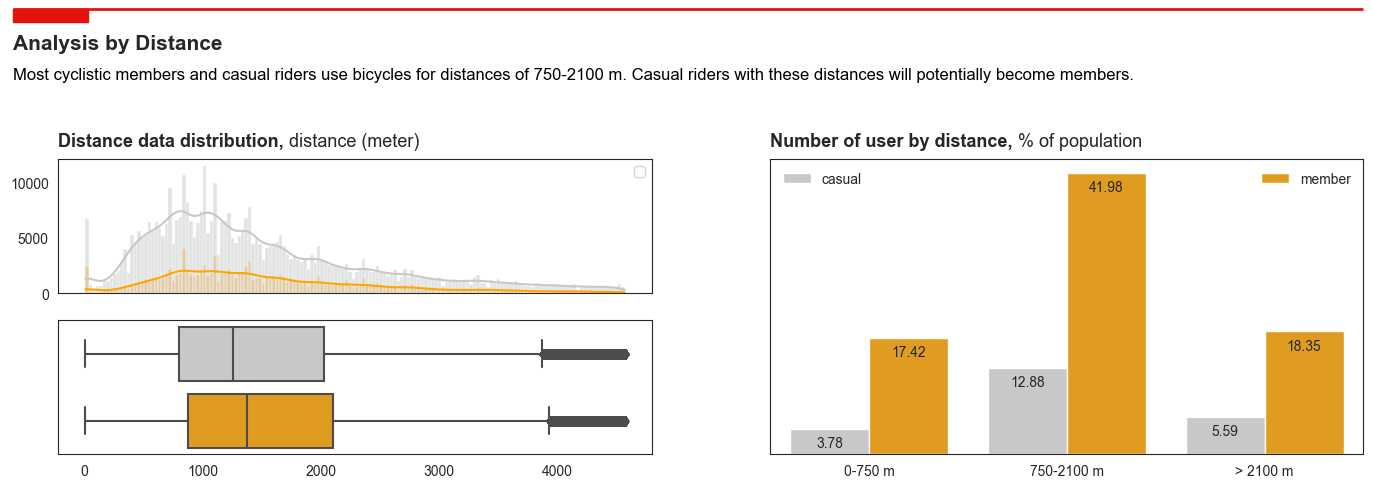

In [22]:
# set the data
Q1_distance = df['distance'].quantile(0.25)
Q3_distance = df['distance'].quantile(0.75)
IQR_distance = Q3_distance - Q1_distance

df_dist = df.query('(@Q1_distance - 1.5 * @IQR_distance) <= distance <= (@Q3_distance + 1.5 * @IQR_distance)')

# figure size
fig = plt.figure(figsize=(15, 5))

# backgorund color
sns.set_style("white")

# axes configuration
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[:, 1])

# make room below on top and bottom
fig.subplots_adjust(top=0.7, left=0.03)

# add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 0.9], [1, 1], lw=2, color='#E3120B', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='#E3120B'))

# add title
fig.text(
    0, 0.92, "Analysis by Distance", 
    fontsize=15,
    fontweight="bold", 
)

# add subtitle
fig.text(
    0, 0.86, 
    "Most cyclistic members and casual riders use bicycles for distances of 750-2100 m. Casual riders with these distances will potentially become members.", 
    fontsize=12, 
    color='black'
)

# add title for histogram plot
text = "<size:13><weight:bold>Distance data distribution,</> distance (meter)</>"
flexitext(0, 1.2, text, va="top", ax=ax1)

# add title for bar plot
text = "<size:13><weight:bold>Number of user by distance,</> % of population</>"
flexitext(1.2, 1.2, text, va="top", ax=ax1)

# historgram plot
g1 = sns.histplot(
    data=df_dist, 
    x="distance", 
    ax=ax1,
    hue='member_casual', 
    kde=True, 
    palette=['#C5C9C7', '#FFA500'],
)
g1.set(xlabel=None, ylabel=None, xticklabels=[])
g1.legend([])

# boxplot
g2 = sns.boxplot(
    data=df_dist, 
    x="distance", 
    y='member_casual',
    ax=ax2, 
    palette=['#C5C9C7', '#FFA500'],
)
g2.set(xlabel=None, ylabel=None, yticklabels=[])
g2.tick_params(left=False)

# barplot
df_bar = pd.pivot_table(
    data=df_dist,
    index=['member_casual', 'class_distance'],
    values='ride_id',
    aggfunc='count').reset_index()

df_bar['%'] = (df_bar['ride_id']/df_bar['ride_id'].sum()) * 100

g3 = sns.barplot(
    data=df_bar, 
    x="class_distance", 
    y="%", 
    ax=ax3,
    order=['0-750 m', '750-2100 m', '> 2100 m'],
    hue='member_casual',
    palette=['#C5C9C7', '#FFA500'],
)
g3.set(ylabel=None, xlabel=None, yticklabels=[])
g3.tick_params(left=False)
g3.legend(loc='upper right', mode='expand', ncol=2, frameon=False)

# annotation
for bar in g3.patches:
    g3.annotate(
        format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width() / 2, bar.get_height() + 2), 
        ha='center', 
        va='center',
        size=10, 
        xytext=(0, -20),
        textcoords='offset points')
    
# saving figure
plt.savefig('../reports/figures/distance.jpg', bbox_inches='tight')

# show the plot
plt.show()

In [23]:
# set the data
df3 = df.query('(@Q1_duration - 1.5 * @IQR_duration) <= duration <= (@Q3_duration + 1.5 * @IQR_duration)')
df3 = df3.query('(@Q1_distance - 1.5 * @IQR_distance) <= distance <= (@Q3_distance + 1.5 * @IQR_distance)')

df3 = df3.groupby(['class_duration', 'class_distance', 'member_casual'])\
    .agg({'member_casual': 'count'}).rename(columns={'member_casual':'count'}).reset_index()

def convert_color(x):
    if x != 'casual':
        return '#FFA500'
    else:
        return '#C5C9C7'
        
df3 = df3.assign(color=df3.member_casual.apply(lambda x: convert_color(x)))

# build sankey diagram
cat_cols = ['class_duration', 'class_distance']

colorPalette = ['#306998','#FFE873']
labelList = []
colorNumList = []
for catCol in cat_cols:
    labelListTemp =  list(set(df[catCol].values))
    colorNumList.append(len(labelListTemp))
    labelList = labelList + labelListTemp
    
labelList = list(dict.fromkeys(labelList))

colorList = []
for idx, colorNum in enumerate(colorNumList):
    colorList = colorList + [colorPalette[idx]]*colorNum
    
for i in range(len(cat_cols)-1):
    if i==0:
        sourceTargetDf = df3[[cat_cols[i], cat_cols[i+1], 'count', 'color']]
        sourceTargetDf.columns = ['source', 'target', 'count', 'colors']
    else:
        tempDf = df3[[cat_cols[i], cat_cols[i+1], 'count', 'color']]
        tempDf.columns = ['source', 'target', 'count', 'colors']
        sourceTargetDf = pd.concat([sourceTargetDf, tempDf])
    sourceTargetDf = sourceTargetDf.groupby(['source', 'target', 'colors']).agg({'count':'sum'}).reset_index()
    
sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))

data = dict(
    type='sankey',
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label = labelList,
      color = colorList,
    ),
    link = dict(
      source = sourceTargetDf['sourceID'],
      target = sourceTargetDf['targetID'],
      value = sourceTargetDf['count'],
      color = sourceTargetDf['colors']
      
    )
  )

def format_title(title, subtitle=None, subtitle_font_size=15):
    title = f'<b>{title}</b>'
    if not subtitle:
        return title
    subtitle = f'<span style="font-size: {subtitle_font_size}px;">{subtitle}</span>'
    return f'{title}<br>{subtitle}'

layout =  dict(
        title = format_title(
            title='Analysis by Duration & Distance',
            subtitle='Casual rider (grey) with duration 0-7.5 minute and distance 750-2100 m, or with duration >7.5 minute and distance 750-2100 m will be a good candidate to be member.'),
        font_family='DejaVu Sans',
        font_color='black',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01)
    )
    
fig = dict(data=[data], layout=layout)
plotly.offline.plot(fig, filename="../reports/figures/sankey")

iplot(fig)

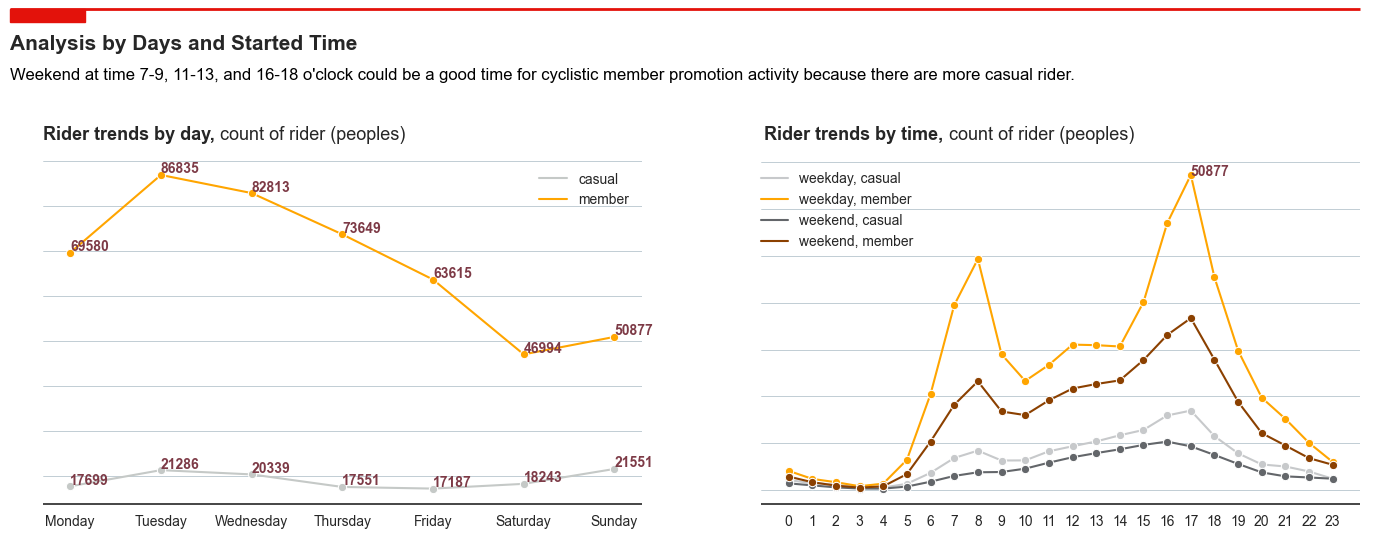

In [24]:
# set the data for first plot
day_dict = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}

df4 = pd.DataFrame(df.groupby(['start_day', 'member_casual'])['ride_id'].agg('count'))\
    .reset_index().sort_values('start_day', key = lambda x : x.apply (lambda x : day_dict[x]))

# set the data for second plot 
df5 = pd.DataFrame(df.groupby(by=[df.start_time.map(lambda x : x.hour), 'weekday', 'member_casual']).ride_id.count()).reset_index()

# initialize plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# make room below on top and bottom
fig.subplots_adjust(top=0.8, left=0.022)

# add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 0.9], [1.1, 1.1], lw=2, color='#E3120B', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.075), 0.05, 0.025, color='#E3120B'))

# add title
fig.text(
    0, 1.02, "Analysis by Days and Started Time", 
    fontsize=15,
    fontweight="bold", 
)

# add subtitle
fig.text(
    0, .960, 
    "Weekend at time 7-9, 11-13, and 16-18 o'clock could be a good time for cyclistic member promotion activity because there are more casual rider.", 
    fontsize=12, 
    color='black'
)

# add title for first line plot
text = "<size:13><weight:bold>Rider trends by day,</> count of rider (peoples)</>"
flexitext(0, 1.1, text, va="top", ax=ax[0])

# add title for second line plot
text = "<size:13><weight:bold>Rider trends by time,</> count of rider (peoples)</>"
flexitext(0.005, 1.1, text, va="top", ax=ax[1])

# background color
sns.set_style("white")

# build first line plot
sns.lineplot(
    data=df4, 
    x='start_day', 
    y='ride_id', 
    hue='member_casual', 
    marker="o",
    palette=['#C5C9C7', '#FFA500'], 
    ax=ax[0], legend=True
).set(xlabel=None, ylabel=None)

# build second line plot
hue = df5[['weekday', 'member_casual']].apply(lambda row: f"{row.weekday}, {row.member_casual}", axis=1)
sns.lineplot(
    data=df5, 
    x='start_time', 
    y='ride_id', 
    hue=hue, 
    errorbar=None,
    marker="o",
    palette=["#C7C9CB", '#FFA500', '#63666A', '#8B4000'], 
    legend=True).set(xlabel=None, ylabel=None)

# add value label on mark point         
for x, y in zip(df4['start_day'], df4['ride_id']):
    ax[0].text(
        x=x, 
        y=y+500,
        s='{:.0f}'.format(y), 
        color="#7d3a46", 
        weight='bold'
    )

ax[1].text(
    x=17, 
    y=df5.ride_id.max(),
    s='{:.0f}'.format(y), 
    color="#7d3a46", 
    weight='bold'
)

# customize y-axis ticks
ax[0].yaxis.set_tick_params(labelleft=False, length=0)
ax[1].yaxis.set_tick_params(labelleft=False, length=0)

# customize x-axis ticks
ax[1].xaxis.set_ticks(list(df5.start_time.unique()))

# make gridlines be below most artists
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)

# add grid lines
ax[0].grid(axis = "y", color="#A8BAC4", lw=0.5)
ax[1].grid(axis = "y", color="#A8BAC4", lw=0.5)

# remove all spines but the one in the bottom
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["left"].set_visible(False)

# customize bottom spine
ax[0].spines["bottom"].set_lw(1.2)
ax[0].spines["bottom"].set_capstyle("butt")
ax[1].spines["bottom"].set_lw(1.2)
ax[1].spines["bottom"].set_capstyle("butt")

# add legend
ax[0].legend(
    loc='upper right',
    frameon=False,
    ncol=1, 
    prop={'size': 10})

ax[1].legend(
    loc='upper left',
    frameon=False,
    bbox_to_anchor=(0., 0.86, 1., .102), 
    mode='expand', 
    ncol=1, 
    borderaxespad=-.46,
    prop={'size': 10})

# saving figure
plt.savefig('../reports/figures/days.jpg', bbox_inches='tight')

# show
plt.show()

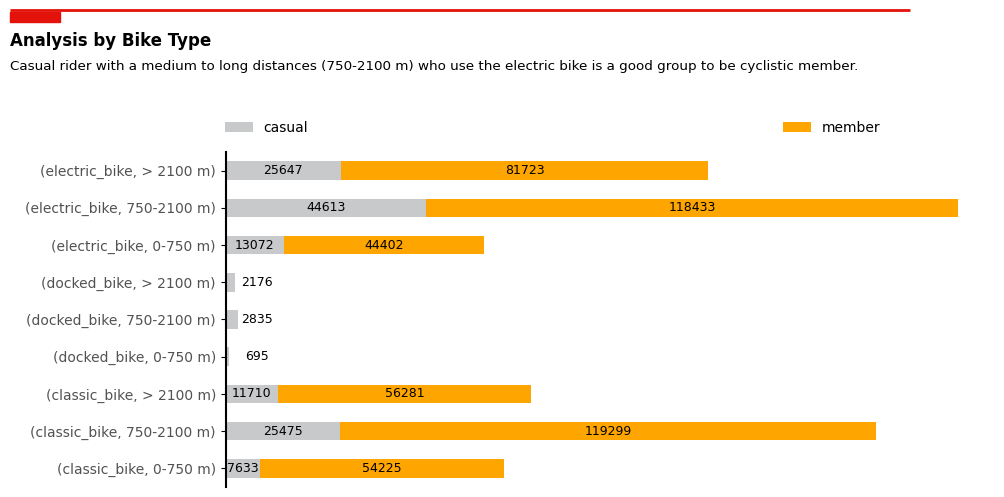

In [13]:
# set the data
df6 = df.groupby(['rideable_type', 'class_distance', 'member_casual']).size()
df6 = df6.unstack()

# initialize plot
fig, ax = plt.subplots()

# adjust the subplot so that the title would fit
plt.subplots_adjust(top=0.9, left=0.2)

# add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 0.9], [1.23, 1.23], lw=2, color='#E3120B', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.2), 0.05, 0.025, color='#E3120B'))

# add title
fig.text(
    0, 1.14, "Analysis by Bike Type", 
    fontsize=12,
    fontweight="bold", 
)

# add subtitle
fig.text(
    0, 1.08, 
    "Casual rider with a medium to long distances (750-2100 m) who use the electric bike is a good group to be cyclistic member.", 
    fontsize=9.7, 
    color='black'
)

# build bar chart
ax = df6.plot.barh(
    align='center', 
    stacked=True, 
    figsize=(10, 4), 
    color=["#C7C9CB", '#FFA500'], 
    ax=ax, 
)
    
# add annotation value on the bar
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 

    if width > 3000:
        X = x+width/2
        Y = y+height/2

    elif width != 0.0:
        X = x+7000
        Y = y+height/2
    
    else:
        continue

    ax.text(
        X, Y, 
        '{:.0f}'.format(width), 
        horizontalalignment='center', 
        verticalalignment='center',
        color='black',
        fontsize=9)

# add legend
legend = plt.legend(
    loc='center',
    frameon=False,
    mode="expand",
    bbox_to_anchor=(0., 1.02, .85, .102), 
    ncol=4, 
    borderaxespad=-.46,
    prop={'size': 10})
    
# set whether axis ticks and gridlines are above or below most artists.
ax.set_axisbelow(True)

# customize axes spine
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)

# customize ticks and label
plt.yticks(color='#525252')
plt.ylabel(ylabel=None)
plt.xticks(ticks=[])
plt.xlabel(xlabel=None)

# saving figure
plt.savefig('../reports/figures/bike.jpg', bbox_inches='tight')

# show
plt.tight_layout()
plt.show()

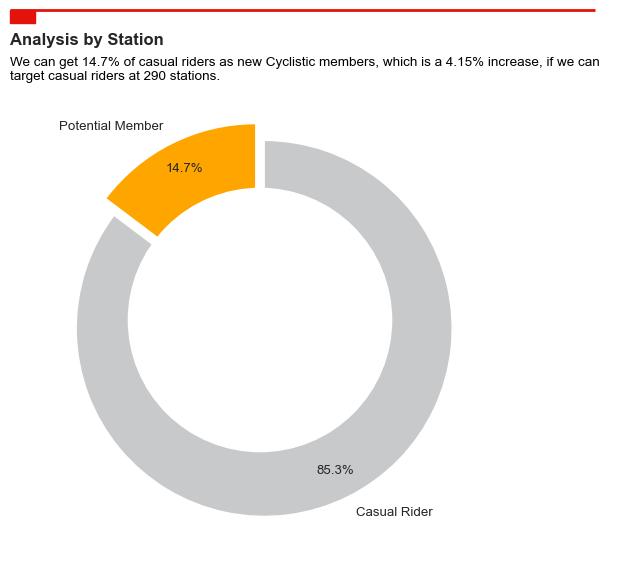

In [26]:
# initialize plot
fig, ax = plt.subplots(figsize=(5, 5))

# adjust the subplot so that the title would fit
plt.subplots_adjust(top=0.9)

# add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1.17], [1.12, 1.12], lw=2, color='#E3120B', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color='#E3120B'))

# add title
fig.text(
    0, 1.05, "Analysis by Station", 
    fontsize=12,
    fontweight="bold", 
)

# add subtitle
fig.text(
    0, 0.98, 
    "We can get 14.7% of casual riders as new Cyclistic members, which is a 4.15% increase, if we can \
        \ntarget casual riders at 290 stations.",
    fontsize=9.7, 
    color='black'
)

# create pie chart
plt.pie([19712, 114144], 
        colors=['#FFA500', "#C7C9CB"],
        labels=['Potential Member', 'Casual Rider'], 
        autopct='%1.1f%%', 
        startangle=90, 
        pctdistance=0.85, 
        explode=(0.05, 0.05),
        textprops = {"fontsize": 9.5},
)

# create a circle at the center of the plot
fig = plt.gcf()
fig.gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'))

# saving figure
plt.savefig('../reports/figures/station.jpg', bbox_inches='tight')

# show
plt.tight_layout()
plt.show()

In [27]:
import folium
from folium.plugins import HeatMap

df_station = df.query("member_casual == 'casual'")

df_station = df_station.groupby(
    [pd.Grouper(key='started_at', freq='D'), pd.Grouper(key='start_station_name'), pd.Grouper(key='end_station_name')]
    ).agg('count').reset_index()

df_station = pd.pivot_table(
    data=df_station[['start_station_name', 'end_station_name', 'ride_id']],
    index=['start_station_name', 'end_station_name'],
    aggfunc='mean'
    ).rename(columns={'ride_id': 'avg'}).nlargest(500, 'avg')

for id in df_station.index:
    df_station.loc[id, 'count'] = df.query("start_station_name == @id[0] and end_station_name == @id[1]").shape[0]
    df_station.loc[id, ['lat', 'lng']] = df.query("start_station_name == @id[0]")[['start_lat', 'start_lng']].sample(1).values

maps = folium.Map(location=[41.881832, -87.623177], zoom_start=14, width=500, height=650)

mouse_position = folium.plugins.MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
)

maps.add_child(mouse_position)

HeatMap(
    data=df_station.reset_index().melt(id_vars=['lat', 'lng'], value_vars=['start_station_name', 'end_station_name'])[['lat', 'lng']],
    min_opacity=0.2, 
    blur=20).add_to(folium.FeatureGroup(name='Heat Map of Start Station').add_to(maps))

folium.Rectangle(bounds=[(41.895, -87.615), (41.889, -87.608)], color='#ff7800', fill_color='#ffff00', fill=False, fill_opacity=0.5).add_to(maps)
folium.Rectangle(bounds=[(41.868, -87.610), (41.863, -87.604)], color='#ff7800', fill_color='#ffff00', fill=False, fill_opacity=0.5).add_to(maps)
folium.Rectangle(bounds=[(41.887, -87.627), (41.878, -87.621)], color='#ff7800', fill_color='#ffff00', fill=False, fill_opacity=0.5).add_to(maps)
folium.Rectangle(bounds=[(41.869, -87.618), (41.864, -87.612)], color='#ff7800', fill_color='#ffff00', fill=False, fill_opacity=0.5).add_to(maps)

folium.LayerControl().add_to(maps)

maps.save("../reports/figures/heatmap.html")
maps

## `Recommendation`

* `Station` : To increase the number of cyclistic members by the end of this quarter (Q1), there are 290 most-used stations in marked zone. If we could convert all of the cyclistic members who usually use the bike for commuting at those stations, there will be a 4.15% increase in the amount of cyclistic members.

* `Time` : Run promotion program when people commute in the morning (7:00 - 9:00 A.M), in lunchtime (11:00 AM - 1:00 PM), or in the afternoon (4:00 - 6:00 PM) because at this time there is much casual rider in Chicago.

* `Bike Type` : Never target docked bike user, just target casual riders who use electric bikes or classic bikes. First target the electric sic bike users, then target the classic bike users.

* `Duration and Distance` : Target the casual rider who use the bike with a duration of 0-7.5 minute or > 7.5 minute for distance 750-2100 m first, then the second target is the group with a duration > 7.5 minutes and distance of > 2100 m.